#Курсовая работа "Мегафон"

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

In [0]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [0]:
# !python3 "/content/drive/My Drive/Colab Notebooks/WOE_IV.py"

Импортируем пакеты

In [0]:

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import sklearn
from datetime import datetime, date
import holidays
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score
from scipy import interp
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from pandas import Series
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
# from WOE_IV import data_vars
import pickle

In [0]:
# from google.colab import files
# files.upload()


In [0]:
# RF=holidays.RU(years =[2019,2020])

#LOAD

In [0]:
TRAIN_PATH = '/content/drive/My Drive/Megafon/Копия data_train.csv'
TEST_PATH = '/content/drive/My Drive/Megafon/Копия data_test.csv'
FEATURES_ZIP_PATH ='/content/drive/My Drive/Features/features.csv 2(1).zip'
FEATURES_PATH ='/content/drive/My Drive/Features/features.csv'
ANSWER_PATH = '/content/drive/My Drive/Megafon/answer_meg.csv'
MODEL_FILE_PATH = '/content/drive/My Drive/Megafon/model.pkl'
TARGET = ['target']

In [69]:
data = pd.read_csv(TRAIN_PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB


In [0]:
def view_matrix(df_train):
    
    '''показывает пропуски по колонкам и общую информацию о сете'''
    
    for colname in df_train.select_dtypes(include='object').columns:
        print(str(colname) + '\n\n' + str(df_train[colname].value_counts()) + '\n' + '*' * 100 + '\n')
    
    msno.matrix(df_train) 
    display("/usr/local/share/datasets/matrix_sorted.png")
    
    print(df_train.head())
    print(len(df_train) - df_train.count(), df_train.info())
    print('===================================')
    print("Дубли в строках    ", df_train.duplicated().sum())
    print("Дубли в ID    ", df_train['id'].duplicated().sum())


'/usr/local/share/datasets/matrix_sorted.png'

   Unnamed: 0       id  vas_id    buy_time  target
0           0   540968     8.0  1537131600     0.0
1           1  1454121     4.0  1531688400     0.0
2           2  2458816     1.0  1534107600     0.0
3           3  3535012     5.0  1535922000     0.0
4           4  1693214     1.0  1535922000     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB
Unnamed: 0    0
id            0
vas_id        0
buy_time      0
target        0
dtype: int64 None
Дубли в строках     0
Дубли в ID     25040


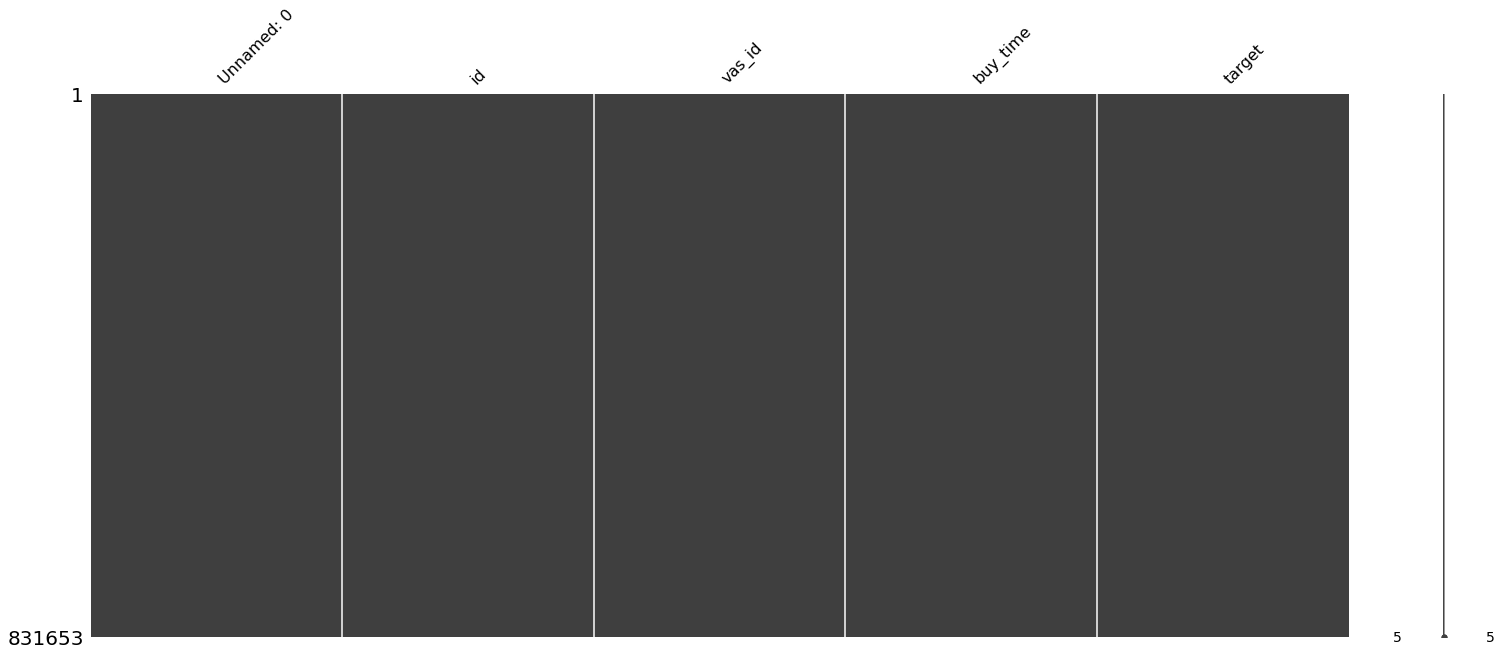

In [71]:
view_matrix(data)


Пропусков нет.
Дубли по ID  в датасете есть. 
От них избавимся чуть позже.

Увеличим число временных признаков для утрирования датасета


In [0]:
data = data.rename(columns={'Unnamed: 0': 'index'})
# data = data.set_index('index')
data['date'] = list(map(datetime.fromtimestamp,data['buy_time']))
data['month'] = data['date'].apply(lambda x: x.timetuple()[1])
data['days'] = data['date'].apply(lambda x: x.timetuple()[7])
# data['year'] = data['date'].map(lambda x: x.year)
data['hour'] = data['date'].map(lambda x: x.hour)
data['is_holiday'] = data['date'].map(lambda x: x in holidays.RU())
first_diff_l =np.log(data.iloc[1:,3].values) 
data['diff1_l'] = 0
data['diff1_l'] =  data['diff1_l'].astype('float') 
data['diff1_l'].values[1:] = first_diff_l
# data.info()
data = data.drop(['date'],axis=1)

'/usr/local/share/datasets/matrix_sorted.png'

   index       id  vas_id    buy_time  ...  days  hour  is_holiday    diff1_l
0      0   540968     8.0  1537131600  ...   259    21       False   0.000000
1      1  1454121     4.0  1531688400  ...   196    21       False  21.149636
2      2  2458816     1.0  1534107600  ...   224    21       False  21.151215
3      3  3535012     5.0  1535922000  ...   245    21       False  21.152397
4      4  1693214     1.0  1535922000  ...   245    21       False  21.152397

[5 rows x 10 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   index       831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
 5   month       831653 non-null  int64  
 6   days        831653 non-null  int64  
 7   hour        831

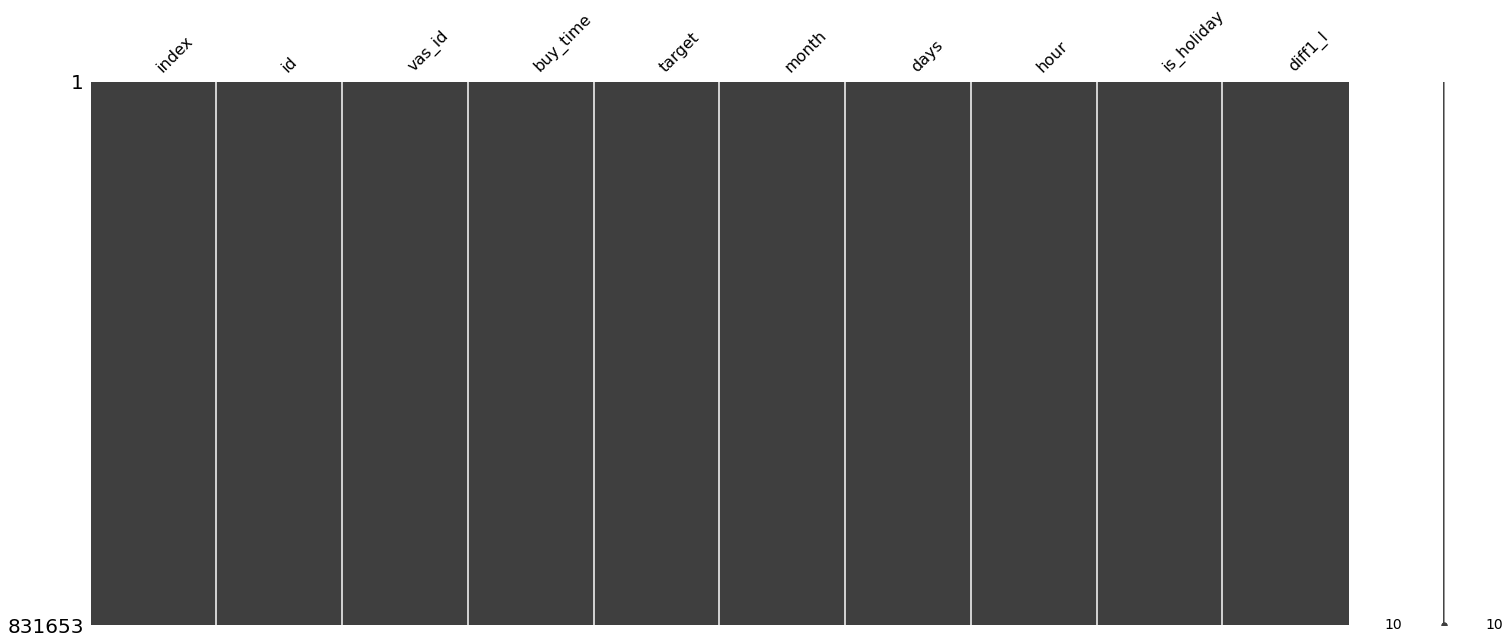

In [73]:
view_matrix(data)


Переведем булевое "is_holiday" в нумеричсую метку

In [0]:
def prepare_label(df_train):
    '''функция преобразующая объекты в метки'''
    
    le = LabelEncoder()

    for col in df_train.columns:       
        if df_train[col].dtypes=='bool':
            df_train[col]=le.fit_transform(df_train[col].astype(float))
    return df_train   

In [75]:
data = prepare_label(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   index       831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
 5   month       831653 non-null  int64  
 6   days        831653 non-null  int64  
 7   hour        831653 non-null  int64  
 8   is_holiday  831653 non-null  int64  
 9   diff1_l     831653 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 63.5 MB


Извлечем данные из 'features.csv 2(1).zip' и соединим их в тренировочный датасет 

In [0]:
chunksize = 10**7
df_features = []
for gm_chunk in pd.read_csv('/content/drive/My Drive/Megafon/features.csv',
                            # '/content/drive/My Drive/Features/features.csv 2(1).zip',
                            sep='\t', 
                            chunksize=chunksize, 
                            # compression='zip', 
                            # nrows=200_000
                            ):
    df_features.append(data.merge(gm_chunk,  on=('id','buy_time')))

'/usr/local/share/datasets/matrix_sorted.png'

   index       id  vas_id    buy_time  ...       249        250      251  252
0    108  1631111     7.0  1544994000  ... -0.694428  14.824067 -0.45614  1.0
1    634  4341324     1.0  1534712400  ... -0.694428 -12.175933 -0.45614  0.0
2   1417   832134     1.0  1533502800  ... -0.694428 -12.175933 -0.45614  1.0
3   1616  1232915     2.0  1546203600  ... -0.694428 -12.175933 -0.45614  0.0
4   3690  1564770     1.0  1541365200  ... -0.694428 -12.175933 -0.45614  0.0

[5 rows x 264 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1864 entries, 0 to 1863
Columns: 264 entries, index to 252
dtypes: float64(256), int64(8)
memory usage: 3.8 MB
index       0
id          0
vas_id      0
buy_time    0
target      0
           ..
248         0
249         0
250         0
251         0
252         0
Length: 264, dtype: int64 None
Дубли в строках     0
Дубли в ID     0


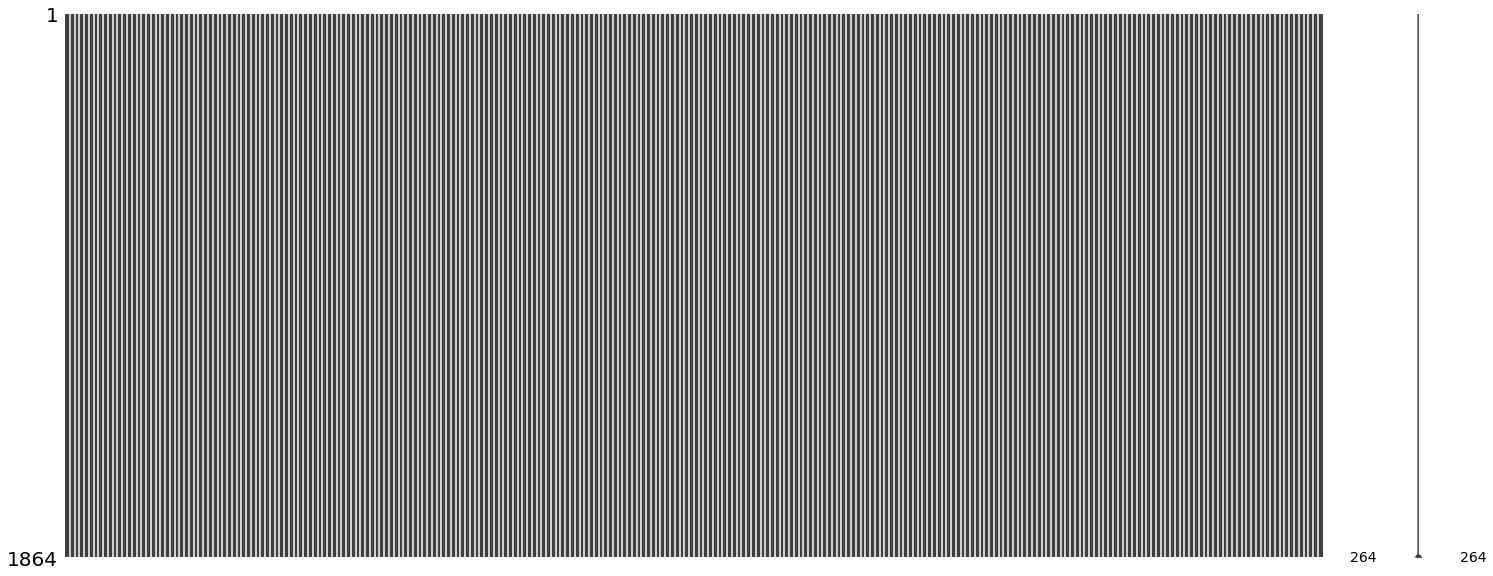

In [77]:
df_merged = pd.concat(df_features)
view_matrix(df_merged)

Дубли устранились. 
Датасет готов к выбору признаков.



# FEATURES


In [0]:
# наборы для отбора признаков
X_f=df_merged.drop(['target'], axis=1)
y_f=df_merged['target']

Информационная ценность (IV) - один из наиболее полезных методов выбора важных переменных в прогнозной модели. Это помогает ранжировать переменные на основе их важности.
Информационная ценность увеличивается по мере того, как ячейки / группы увеличиваются для независимой переменной. Хорошо подходит для бинарной логистической регрессии.

Применим этот прием здесь.

In [0]:
# 

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
# Code below throws AttributeError: 'NoneType' object has no attribute 'groups'    
#     stack = traceback.extract_stack()
#     filename, lineno, function_name, code = stack[-2]
#     vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
#     final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
#         if i.upper() not in (final.upper()):
        if True:
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

Сделаем отбор признаков на основе их информационной важности.

In [0]:
iv_df, iv = data_vars(X_f, y_f)

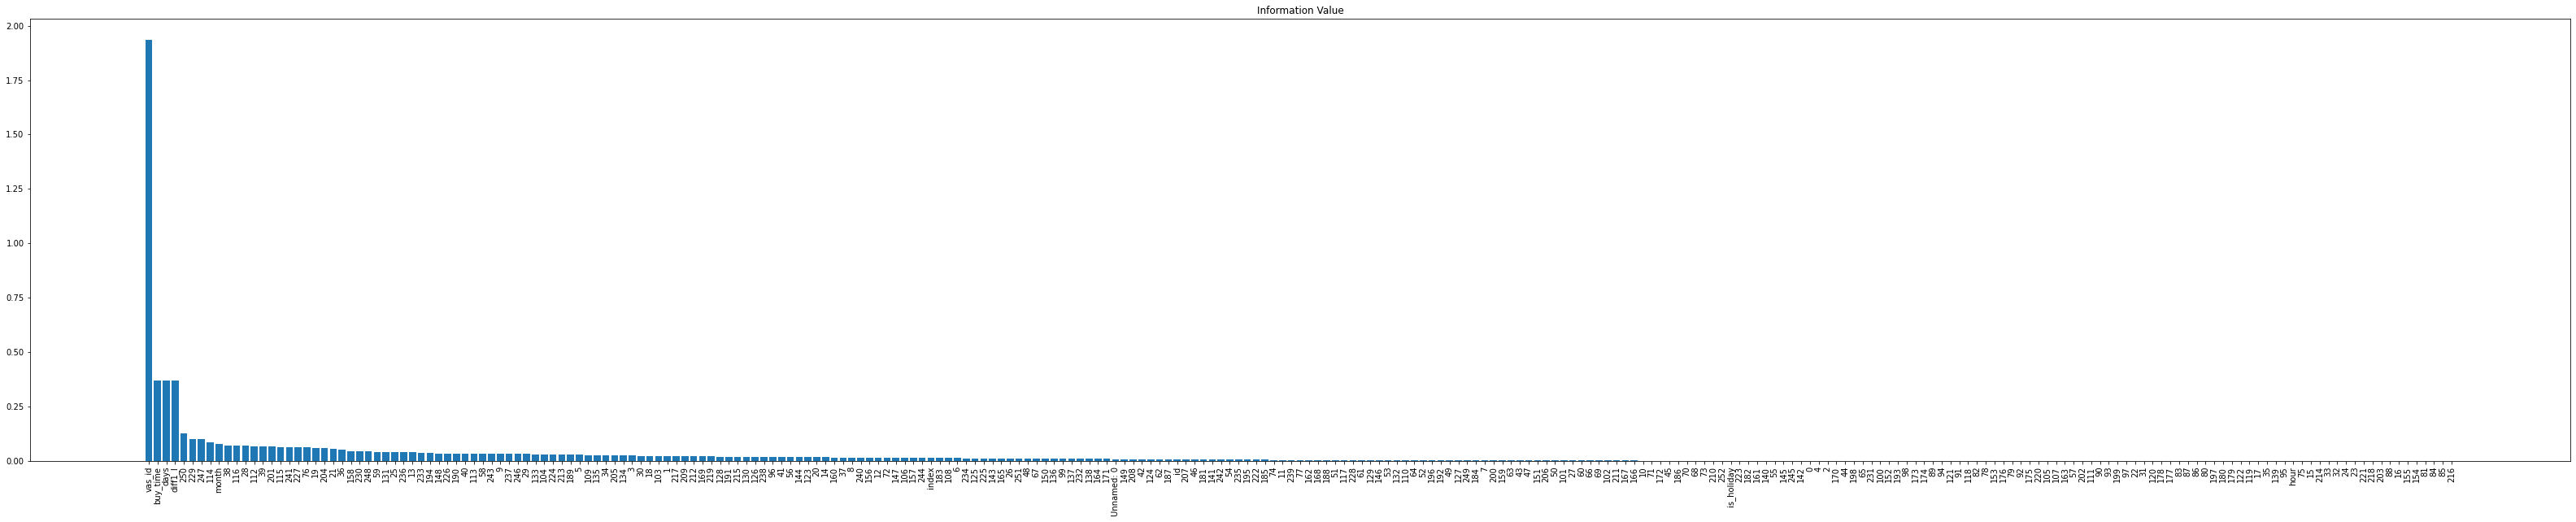

Значимых признаков: 100


['buy_time',
 'days',
 'diff1_l',
 '250',
 '229',
 '247',
 '114',
 'month',
 '38',
 '116',
 '28',
 '112',
 '39',
 '201',
 '115',
 '241',
 '227',
 '76',
 '19',
 '204',
 '21',
 '36',
 '158',
 '230',
 '248',
 '59',
 '131',
 '25',
 '236',
 '13',
 '233',
 '194',
 '148',
 '226',
 '190',
 '40',
 '113',
 '58',
 '243',
 '9',
 '237',
 '246',
 '29',
 '133',
 '104',
 '224',
 '213',
 '189',
 '5',
 '109',
 '135',
 '34',
 '205',
 '134',
 '3',
 '30',
 '18',
 '103',
 '1',
 '217',
 '209',
 '212',
 '169',
 '219',
 '128',
 '191',
 '215',
 '130',
 '126',
 '238',
 '96',
 '41',
 '56',
 '144',
 '123',
 '20',
 '14',
 '160',
 '37',
 '8',
 '240',
 '156',
 '12',
 '72',
 '147',
 '106',
 '157',
 '244',
 'index',
 '183',
 '108',
 '6',
 '234',
 '125',
 '225',
 '143',
 '165',
 '26',
 '251',
 '48']

In [81]:
IV = iv.sort_values('IV', ascending=False)
plt.figure(figsize=(56,10))
plt.bar(range(IV.shape[0]), IV['IV'], align='center')
plt.xticks(range(IV.shape[0]), IV['VAR_NAME'].values, rotation=90)
plt.title('Information Value')
plt.show()

# Выделим значимые признаки, для таких признаков IV не должно быть близко ни к 0, ни к 1
significant_features = IV.loc[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME']
print('Значимых признаков:', significant_features.nunique())
FEATS = list(significant_features)
FEATS
# TARGET in FEATS

Преобразуем признаки содержащие только 10 и менее уникальных значений в категорийные 


In [82]:
cat_val_uniq = 10

cat_val_share = cat_val_uniq / df_merged.shape[0]
cat_val_share, df_merged.shape[0]

(0.00536480686695279, 1864)

Разделим признаки на нумерические и категорийные.

In [83]:

converted_obj = pd.DataFrame()
converted_num = pd.DataFrame()
for col in df_merged[FEATS].columns:
    num_unique_values = len(df_merged[col].unique())
    num_total_values = len(df_merged[col])
    if num_unique_values / num_total_values < cat_val_share: #0.0053
        converted_obj.loc[:,col] = df_merged[col].astype('category')
    else:
        converted_num.loc[:,col] = df_merged[col].astype('float64', 'int64')

converted_obj.info()
converted_num.info() #, list(converted_obj.select_dtypes(include= 'category').drop(['target'], axis=1))
CAT_FEATS=list(converted_obj.select_dtypes(include= 'category'))
NUM_FEATS=list(converted_num.select_dtypes(include= 'number'))
# NUM_FEATS=list(converted_num.select_dtypes(include= 'number').drop(['buy_time'], axis=1))
# NUM_FEATS
CAT_FEATS
# TARGET in CAT_FEATS, TARGET in NUM_FEATS, TARGET in FEATS

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1864 entries, 0 to 1863
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   month   1864 non-null   category
 1   28      1864 non-null   category
 2   201     1864 non-null   category
 3   204     1864 non-null   category
 4   131     1864 non-null   category
 5   194     1864 non-null   category
 6   29      1864 non-null   category
 7   189     1864 non-null   category
 8   205     1864 non-null   category
 9   30      1864 non-null   category
 10  212     1864 non-null   category
 11  215     1864 non-null   category
 12  26      1864 non-null   category
dtypes: category(13)
memory usage: 40.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1864 entries, 0 to 1863
Data columns (total 87 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   buy_time  1864 non-null   float64
 1   days      1864 non-null   float64
 2   diff1_l   18

['month',
 '28',
 '201',
 '204',
 '131',
 '194',
 '29',
 '189',
 '205',
 '30',
 '212',
 '215',
 '26']

In [0]:

# cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value='MISSING'))
cat_si_step = ('si', SimpleImputer(strategy='constant'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step, num_ss_step]

num_pipe = Pipeline(num_steps)


In [85]:
# обьединение

transformers = [('cat', cat_pipe, CAT_FEATS),
                ('num', num_pipe, NUM_FEATS)]

ct_all = ColumnTransformer(transformers=transformers)

X = ct_all.fit_transform(df_merged[FEATS])
X.shape

(1864, 139)

In [86]:
# X = df_merged.drop(['target'], axis=1)
y = df_merged['target']
# X.info()
TARGET in X

False

# SPLIT & BALANCE

In [87]:
print('Before sampled dataset shape %s' % Counter(y))

Before sampled dataset shape Counter({0.0: 1734, 1.0: 130})


Есть дисбаланс классов таргете. 

Разобьём и отбалансируем подготовленнные наборы

In [88]:
X_train_WOE, X_test_WOE, y_train_WOE, y_test_WOE = train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.6,
                                                                    shuffle=True, 
                                                                    stratify=y, 
                                                                    random_state=100)
X_train_WOE_balanced, y_train_WOE_balanced = SMOTE(random_state=42, ratio=.45).fit_sample(X_train_WOE, y_train_WOE)
print('Before sampled dataset shape %s' % Counter(y_train_WOE))
print('After sampled dataset shape %s' % Counter(y_train_WOE_balanced))
print(X_train_WOE_balanced.shape, y_train_WOE_balanced.shape)


Before sampled dataset shape Counter({0.0: 693, 1.0: 52})
After sampled dataset shape Counter({0.0: 693, 1.0: 311})
(1004, 139) (1004,)


In [0]:
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

In [0]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

# MODELS


В рамках этой работы посмотрим как отработают три модели - LogisticRegression, XGBClassifer и 

In [0]:
RANDOM_STATE=42

In [92]:
%%time
logit = LogisticRegression(random_state=42)
logit.fit(X_train_WOE_balanced, y_train_WOE_balanced)
# logit.fit(X_resampled, y_resampled)


predict_proba_test = logit.predict_proba(X_test_WOE)
predict_train = logit.predict(X_train_WOE)
predict_test = logit.predict(X_test_WOE)


get_classification_report(y_train_WOE, predict_train, y_test_WOE, predict_test)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, predict_test, predict_proba_test[:, 1])

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       693
         1.0       0.34      0.52      0.41        52

    accuracy                           0.90       745
   macro avg       0.65      0.72      0.68       745
weighted avg       0.92      0.90      0.91       745

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90      1041
         1.0       0.11      0.22      0.14        78

    accuracy                           0.82      1119
   macro avg       0.52      0.54      0.52      1119
weighted avg       0.88      0.82      0.85      1119

CONFUSION MATRIX

col_0   0.0  1.0
target          
0.0     901  140
1.0      61   17
Precision: 0.10828025477707007
Recall: 0.21794871794871795
F1: 0.1446808510638298
Log Loss: 0.5555691661646747
ROC AUC: 0.5906672578142318
CPU times: user 115 ms, sys: 62.9 ms, total: 178 ms
Wall time: 91.2 ms


In [0]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    '''отбирает лучшие параметры модели '''
    # gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)
    gsc = RandomizedSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc, gsc.best_params_

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Подберем параметры для модели LogisticRegression


In [0]:

param_grid ={ 
'penalty':['l1', 'l2', 'elasticnet', 'none'], 
'C':[0.5, 1.0, 2.0],
'max_iter': [50,100,150,200],
'intercept_scaling' :[0.5,1.0,1.5, 2.0],
'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
'random_state':[10,50,100,200,300,400]
}


# log_gsc, log_gsc.best_params_ = run_grid_search(logit, X_train_WOE_balanced, y_train_WOE_balanced, param_grid, kfold_cv)

Применим отобранные параметры к LogisticRegression

In [96]:

last_model =LogisticRegression(solver='newton-cg', 
                               penalty='l2', 
                               max_iter=200, 
                               intercept_scaling=1.5,
                               C=0.5, 
                               random_state=200)
last_model.fit(X_train_WOE_balanced, y_train_WOE_balanced)


y_train_pred_c = last_model.predict(X_train_WOE)
y_test_pred_c= last_model.predict(X_test_WOE)
y_test_pred_probs_c = last_model.predict_proba(X_test_WOE)

get_classification_report(y_train_WOE, y_train_pred_c, y_test_WOE, y_test_pred_c)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, y_test_pred_c, y_test_pred_probs_c[:, 1])



TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       693
         1.0       0.35      0.54      0.42        52

    accuracy                           0.90       745
   macro avg       0.65      0.73      0.68       745
weighted avg       0.92      0.90      0.91       745

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      1041
         1.0       0.11      0.19      0.14        78

    accuracy                           0.83      1119
   macro avg       0.52      0.54      0.52      1119
weighted avg       0.88      0.83      0.85      1119

CONFUSION MATRIX

col_0   0.0  1.0
target          
0.0     915  126
1.0      63   15
Precision: 0.10638297872340426
Recall: 0.19230769230769232
F1: 0.136986301369863
Log Loss: 0.49737681376400356
ROC AUC: 0.5997561516293505


Посмотрим как отработает XGBoost

In [97]:


clf = xgb.XGBClassifier(random_state=42, max_depth=6)
clf.fit(X_train_WOE_balanced, y_train_WOE_balanced)


y_train_pred_x = clf.predict(X_train_WOE)
y_test_pred_x= clf.predict(X_test_WOE)
y_test_pred_probs_x = clf.predict_proba(X_test_WOE)

get_classification_report(y_train_WOE, y_train_pred_c, y_test_WOE, y_test_pred_x)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, y_test_pred_x, y_test_pred_probs_x[:, 1])

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       693
         1.0       0.35      0.54      0.42        52

    accuracy                           0.90       745
   macro avg       0.65      0.73      0.68       745
weighted avg       0.92      0.90      0.91       745

TEST

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1041
         1.0       0.30      0.08      0.12        78

    accuracy                           0.92      1119
   macro avg       0.62      0.53      0.54      1119
weighted avg       0.89      0.92      0.90      1119

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1027   14
1.0       72    6
Precision: 0.3
Recall: 0.07692307692307693
F1: 0.12244897959183675
Log Loss: 0.30576073020740124
ROC AUC: 0.58166457301904


In [0]:
# param_grid ={ 'gamma':[0,0.5,1.,1,5,2.],
#                'max_depth':[2,4,6,8,10],
#               'n_estimators':[100,200,300,400,500,1000],
#               'learning_rate':[0.01,0.05,0.1,0.2,0.3],
#               'nthread':[1,5,10],
#               'subsample':[.5,1.,1.5],
#               'colsample_bytree':[0.5,1.,1.5,2.0,2,5],
#               'min_child_weight':[1,2,3,4,5,6,7,8,9],
#               'reg_alpha':[0.,.5,1.,2.,3.],
#               'reg_lambda':[0.],
#               'seed':[42,102],
#               'missing':[1e10]
# }


# xgb_gsc = run_grid_search(clf, X_train_WOE_balanced, y_train_WOE_balanced, param_grid, kfold_cv)

In [99]:
clf_fin = xgb.XGBClassifier (gamma=1.,
                            subsample=1.0, 
                            seed =102, 
                            reg_lambda=0.0, 
                            reg_alpha=0.0, 
                            nthread=1,
                            n_estimators=100, 
                            missing=10000000000.0, 
                            min_child_weight=4, 
                            max_depth=4, 
                            learning_rate=0.3, 
                            colsample_bytree =0.5)
clf_fin.fit(X_train_WOE_balanced, y_train_WOE_balanced)


y_train_pred_f = clf_fin.predict(X_train_WOE)
y_test_pred_f= clf_fin.predict(X_test_WOE)
y_test_pred_probs_f = clf_fin.predict_proba(X_test_WOE)

get_classification_report(y_train_WOE, y_train_pred_f, y_test_WOE, y_test_pred_f)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, y_test_pred_f, y_test_pred_probs_f[:, 1])

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       693
         1.0       1.00      0.94      0.97        52

    accuracy                           1.00       745
   macro avg       1.00      0.97      0.98       745
weighted avg       1.00      1.00      1.00       745

TEST

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1041
         1.0       0.25      0.06      0.10        78

    accuracy                           0.92      1119
   macro avg       0.59      0.52      0.53      1119
weighted avg       0.89      0.92      0.90      1119

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1026   15
1.0       73    5
Precision: 0.25
Recall: 0.0641025641025641
F1: 0.1020408163265306
Log Loss: 0.3037092256996594
ROC AUC: 0.6227862755240277


Модель упорно определяет ложными(37+5) меток. Идентификация 'target':1.0 проходит неудовлетворительно

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB

In [0]:
para=({'fit_prior': False, 'class_prior': None, 'binarize': 0.0, 'alpha': 0.1})

In [102]:
# gnb = GaussianNB()
# gnb = MultinomialNB()
gnb = BernoulliNB(alpha=0.05, 
                  binarize=0.0,
                  fit_prior=False, 
                  class_prior=None)
gnb.fit(X_train_WOE_balanced, y_train_WOE_balanced)


y_train_pred_f = gnb.predict(X_train_WOE)
y_test_pred_f= gnb.predict(X_test_WOE)
y_test_pred_probs_f = gnb.predict_proba(X_test_WOE)

get_classification_report(y_train_WOE, y_train_pred_f, y_test_WOE, y_test_pred_f)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, y_test_pred_f, y_test_pred_probs_f[:, 1])
gnb.get_params().keys()

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82       693
         1.0       0.15      0.65      0.24        52

    accuracy                           0.71       745
   macro avg       0.56      0.68      0.53       745
weighted avg       0.91      0.71      0.78       745

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.72      0.82      1041
         1.0       0.11      0.44      0.17        78

    accuracy                           0.70      1119
   macro avg       0.52      0.58      0.49      1119
weighted avg       0.89      0.70      0.77      1119

CONFUSION MATRIX

col_0   0.0  1.0
target          
0.0     752  289
1.0      44   34
Precision: 0.10526315789473684
Recall: 0.4358974358974359
F1: 0.16957605985037405
Log Loss: 1.7880914810588262
ROC AUC: 0.6282790216507796


dict_keys(['alpha', 'binarize', 'class_prior', 'fit_prior'])

В этой модели абсолютное самое большое количество обнаруженных 'target: 1.0', но но итоговвая ошибка самая большая

In [103]:
param_b ={ 
               'alpha':[0.1,0.5,1.,1.5,2.0,3.0,],
'binarize':[0.0, 0.5,1.5,2.0],
'fit_prior':[True, False],
'class_prior':[None, 1.,2.,10.]
}


xgb_gsc = run_grid_search(gnb, X_train_WOE_balanced, y_train_WOE_balanced, param_b, kfold_cv)

Best roc_auc score: 0.83

Best parameters set found on development set:

{'fit_prior': True, 'class_prior': None, 'binarize': 0.0, 'alpha': 0.1}

Grid scores on development set:

nan (+/-nan) for {'fit_prior': True, 'class_prior': 1.0, 'binarize': 0.5, 'alpha': 2.0}
nan (+/-nan) for {'fit_prior': True, 'class_prior': 1.0, 'binarize': 0.5, 'alpha': 1.5}
nan (+/-nan) for {'fit_prior': False, 'class_prior': 2.0, 'binarize': 1.5, 'alpha': 1.5}
nan (+/-nan) for {'fit_prior': True, 'class_prior': 10.0, 'binarize': 1.5, 'alpha': 0.1}
0.829 (+/-0.026) for {'fit_prior': True, 'class_prior': None, 'binarize': 0.0, 'alpha': 0.1}
nan (+/-nan) for {'fit_prior': False, 'class_prior': 10.0, 'binarize': 1.5, 'alpha': 1.0}
0.826 (+/-0.026) for {'fit_prior': False, 'class_prior': None, 'binarize': 0.0, 'alpha': 0.5}
nan (+/-nan) for {'fit_prior': True, 'class_prior': 1.0, 'binarize': 2.0, 'alpha': 2.0}
nan (+/-nan) for {'fit_prior': False, 'class_prior': 2.0, 'binarize': 0.0, 'alpha': 3.0}
nan (+/-nan) 

Представление итогов работы  лучшей модели

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

def plot_PR_curve(y_true, y_pred, y_prob):
    AP = average_precision_score(y_true=y_true, y_score=y_prob)
    precisions, recalls, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_prob)
    
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve: AP={0:0.2f}'.format(AP))
    
def plot_ROC_curve(classifier, X, y, n_folds):
    
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % \
             (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Рассмотрим поведение лучшей модели: clf_fin

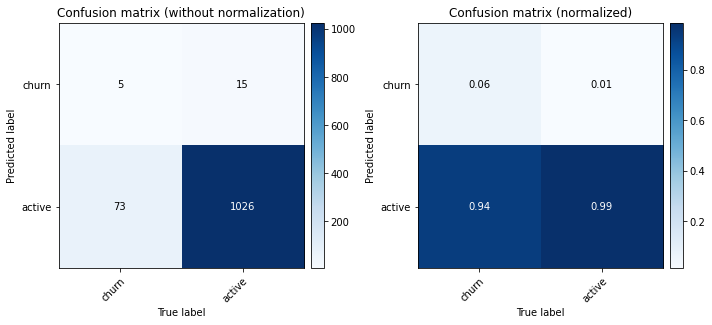

In [106]:
predict_test = clf_fin.predict(X_test_WOE)
predict_test_probas = clf_fin.predict_proba(X_test_WOE)[:, 1]

# predict_test = logit.predict(X_test_WOE)
# predict_test_probas = logit.predict_proba(X_test_WOE)[:, 1]


plot_confusion_matrix(y_test_WOE.values, predict_test, classes=['churn', 'active'])
plt.show()

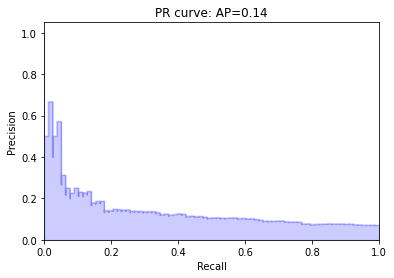

In [107]:
plot_PR_curve(y_test_WOE.values, predict_test, predict_test_probas)
plt.show()

In [0]:
fpr, tpr, roc_thresholds = roc_curve(y_test_WOE, predict_test_probas)
precision, recall, pr_thresholds = precision_recall_curve(y_test_WOE, predict_test_probas)

In [0]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

In [0]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

In [0]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='red', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

Baseline: AUC_ROC = 0.623
Baseline: AUC_PR = 0.135


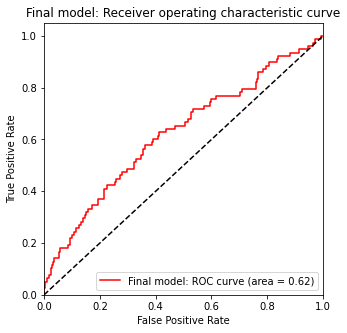

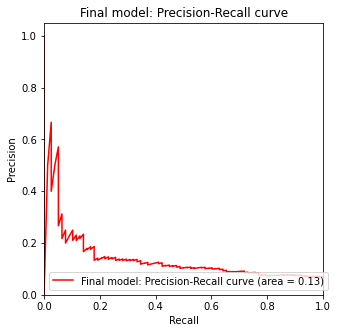

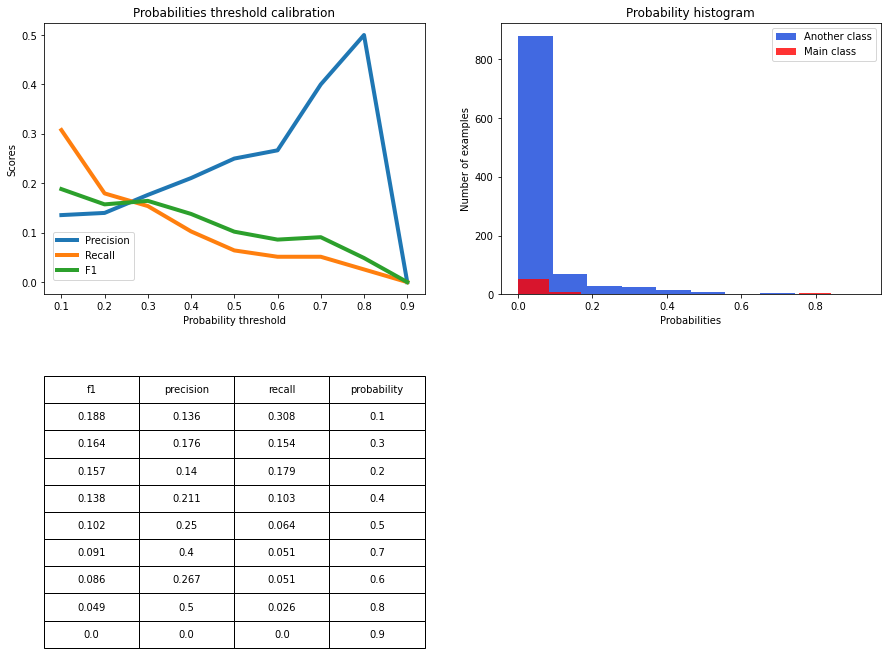

In [112]:

plt.figure(figsize=(5, 5))
plot_roc_curve(fpr, tpr, "Final model", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

plt.figure(figsize=(5, 5))
    
plot_precision_recall_curve(recall, precision, "Final model", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

show_proba_calibration_plots(predict_test_probas, y_test_WOE)

# TEST_WORK

Создадим необходимые функции для обработки тестового набора

In [0]:
def etl_data_megafon(data):
  '''преобразует дату в признаки'''
  data = data.rename(columns={'Unnamed: 0': 'index'})
  # data = data.set_index('index')
  data['date'] = list(map(datetime.fromtimestamp,data['buy_time']))
  data['month'] = data['date'].apply(lambda x: x.timetuple()[1])
  data['days'] = data['date'].apply(lambda x: x.timetuple()[7])
  # data['year'] = data['date'].map(lambda x: x.year)
  data['hour'] = data['date'].map(lambda x: x.hour)
  data['is_holiday'] = data['date'].map(lambda x: x in holidays.RU())
  first_diff_l =np.log(data.iloc[1:,3].values) 
  data['diff1_l'] = 0
  data['diff1_l'] =  data['diff1_l'].astype('float') 
  data['diff1_l'].values[1:] = first_diff_l
  data = data.drop(['date'],axis=1)

  return data

In [0]:
def merged_feats_data(data, FEATURES_PATH):
  '''объединяет два датасета'''
  df_features = []
  for gm_chunk in pd.read_csv(FEATURES_PATH,
                              # '/content/drive/My Drive/Features/features.csv 2(1).zip',
                              sep='\t', 
                              chunksize=chunksize, 
                              # compression='zip', 
                              # nrows=200_000
                              ):
      df_features.append(data.merge(gm_chunk,  on=('id','buy_time')))
      df_merged = pd.concat(df_features)
      return df_merged
   

In [0]:
def test_transform(df_test_m):
  '''преобразует в датафрейме нумерические и категорийные признаки'''
  df_test_ss = df_test_m.copy()
  ss = StandardScaler()
  ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

  transformers = [('cat', ohe, CAT_FEATS),
                  ('num', ss, NUM_FEATS)]

  ct = ColumnTransformer(transformers)
  X_m = ct.fit_transform(df_test_ss[FEATS])
  # X_m = ct.fit_transform(df_test_m)

  return X_m

In [116]:
df_test = pd.read_csv(TEST_PATH)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB


In [117]:
df_test=etl_data_megafon(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
 4   month       71231 non-null  int64  
 5   days        71231 non-null  int64  
 6   hour        71231 non-null  int64  
 7   is_holiday  71231 non-null  bool   
 8   diff1_l     71231 non-null  float64
dtypes: bool(1), float64(2), int64(6)
memory usage: 4.4 MB


In [118]:
df_test_m = merged_feats_data(df_test,FEATURES_PATH)
df_test_m.shape, df_test_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Columns: 263 entries, index to 252
dtypes: bool(1), float64(255), int64(7)
memory usage: 191.2 KB


((93, 263), None)

In [119]:
df_test_t=df_test_m.copy()
df_test_ff=df_test_t[FEATS]
df_test_ff.shape

(93, 100)

In [120]:
# X_test_test=test_transform(df_test_m)
X_test_test = ct_all.transform(df_test_ff)
len(X_test_test)


93

In [121]:
target = clf_fin.predict_proba(X_test_test)[:,1]
# len(target), df_test_m.shape
df_test_m['target'] = target
df_test_m.loc[:,['buy_time', 'id', 'vas_id', 'target']].to_csv(ANSWER_PATH,index=None)
pd.read_csv(ANSWER_PATH).head()

,buy_time,id,vas_id,target
0,1547413200,1033077,5.0,0.116066
1,1546808400,3496850,5.0,0.018790
2,1547413200,2546419,7.0,0.001432
3,1547413200,541971,2.0,0.003459
4,1546808400,2264715,6.0,0.002197


In [0]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(clf_fin, file)